In [0]:
from __future__ import print_function, division
import os
import torch
from torch.optim.optimizer import Optimizer
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from skimage import io
import torch.nn as nn
import torch.nn.functional as F

from skimage.color import rgb2gray

from torch.utils.tensorboard import SummaryWriter

import PIL
from PIL import Image

from google.colab import output

In [2]:
%cd /content/
if(os.path.isdir('/content/Lithuanian_OCR') == False):
  !git clone https://github.com/PauliusMilmantas/Lithuanian_OCR

num_of_classes = 3

/content
Cloning into 'Lithuanian_OCR'...
remote: Enumerating objects: 145, done.
remote: Counting objects: 100% (145/145), done.
remote: Compressing objects: 100% (105/105), done.
remote: Total 4130 (delta 37), reused 136 (delta 29), pack-reused 3985
Receiving objects: 100% (4130/4130), 329.53 MiB | 38.60 MiB/s, done.
Resolving deltas: 100% (655/655), done.


In [0]:
class ORCDataset(Dataset):
  def __init__(self, root):
    self.root = root

  def __len__(self):
    lt = 0
    classes = os.listdir(self.root)
    for cl in classes:
      lt += len(os.listdir(self.root + '/' + cl))

    return lt

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
     idx = idx.tolist()

    if(idx <= len(self)):
      found_file = ""
      found_type = ""

      fldrs = os.listdir(self.root)
      for fld in fldrs:
        fls = os.listdir(self.root + '/' + fld + '/')
        for fl in fls:
          if(fl == str(idx) + ".jpg"):
            found_file = self.root + '/' + fld + '/' + fl         
            found_type = fld

      try:
        img = io.imread(found_file)
        img = rgb2gray(img)

        return {'image': img, 'class_name': found_type}
      except:
        if(found_file != ""):
          print("Bad file: " + found_file)
        else:
          print("File not found, idx = " + str(idx))
    else:
      print()
      raise Exception("Dataset index out of boundaries")

train_dataset = ORCDataset('/content/Lithuanian_OCR/Data/batch-2/training')
val_dataset = ORCDataset('/content/Lithuanian_OCR/Data/batch-2/val')
test_dataset = ORCDataset('/content/Lithuanian_OCR/Data/batch-2/test')

other_train_dataset = ORCDataset('/content/Lithuanian_OCR/Data/batch-1/training')
other_val_dataset = ORCDataset('/content/Lithuanian_OCR/Data/batch-1/val')
other_test_dataset = ORCDataset('/content/Lithuanian_OCR/Data/batch-1/test')

In [0]:
class Net(nn.Module):
    def __init__(self, input_size, hidden1_size, hidden2_size, num_classes):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden1_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden1_size, hidden2_size)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden2_size, num_classes)  
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)        
        out = self.relu2(out)     
        out = self.fc3(out)
        return out

In [0]:
class custom_sgd_optimizer(Optimizer):
    def __init__(self, params, lr, momentum=0, dampening=0,
                 weight_decay=0, nesterov=False):

        defaults = dict(lr=lr, momentum=momentum, dampening=dampening,
                        weight_decay=weight_decay, nesterov=nesterov)
        if nesterov and (momentum <= 0 or dampening != 0):
            raise ValueError("Nesterov momentum requires a momentum and zero dampening")
        super(custom_sgd_optimizer, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(custom_sgd_optimizer, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('nesterov', False)

    @torch.no_grad()
    def step(self, closure=None):
        """Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            weight_decay = group['weight_decay']
            momentum = group['momentum']
            dampening = group['dampening']
            nesterov = group['nesterov']

            for p in group['params']:
                if p.grad is None:
                    continue
                d_p = p.grad
                if weight_decay != 0:
                    d_p = d_p.add(p, alpha=weight_decay)
                if momentum != 0:
                    param_state = self.state[p]
                    if 'momentum_buffer' not in param_state:
                        buf = param_state['momentum_buffer'] = torch.clone(d_p).detach()
                    else:
                        buf = param_state['momentum_buffer']
                        buf.mul_(momentum).add_(d_p, alpha=1 - dampening)
                    if nesterov:
                        d_p = d_p.add(buf, alpha=momentum)
                    else:
                        d_p = buf

                p.add_(d_p, alpha=-group['lr'])

        return loss

In [5]:
network = Net(4096, 1500, 300, num_of_classes)
network.cuda()
optimizer = torch.optim.SGD(network.parameters(), lr=0.0001, momentum=0.6)
criterion = nn.MSELoss().cuda()

print(network)

Net(
  (fc1): Linear(in_features=4096, out_features=1500, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=1500, out_features=300, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=300, out_features=3, bias=True)
)


In [6]:
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
network.to(dev)
criterion.to(dev)
dev

device(type='cuda')

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

Using device: cuda

Tesla P100-PCIE-16GB
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [0]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = len(train_dataset),shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size = len(val_dataset), shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = len(test_dataset), shuffle=True)

other_train_loader = torch.utils.data.DataLoader(other_train_dataset, batch_size = len(other_train_dataset),shuffle=True)
other_val_loader = torch.utils.data.DataLoader(other_val_dataset, batch_size = len(other_val_dataset), shuffle=True)
other_test_loader = torch.utils.data.DataLoader(other_test_dataset, batch_size = len(other_test_dataset), shuffle=True)

Class name: P


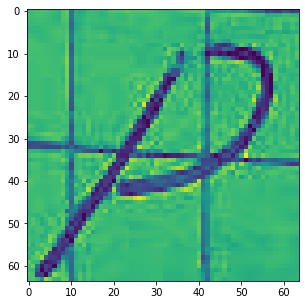

In [9]:
dataiter = iter(train_loader)
itr = dataiter.next()

label = itr['class_name']
img = itr['image']
print("Class name: {}".format(label[0]))

fig = plt.figure(figsize = (5,5)) 
ax = fig.add_subplot(111)
ax.imshow(img[0])

In [0]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(10 + 1)]

In [0]:
!mkdir results

In [0]:
def name_to_int(data):

  switcher = {
      'A': 1,
      'B': 2,
      'C': 3,
      'A_small': 1,
      'P': 2,
      'u': 3
  }

  new_data = []

  for dt in data:
    new_data.append(switcher.get(dt))

  return new_data

def get_max_from_tensor(data):
  maxVal = data[0]
  maxId = 0
  for i in range(len(data)):
    if(data[i] > maxVal):
      maxVal = data[i]
      maxId = i

  return maxId + 1

In [26]:
def train(train_loader, val_loader, epoch_amount, save_checkpoint = 10):
  network.eval()
  train_loss_hist = []
  val_loss_hist = []

  other_train_loss_hist = []

  checkpoint = save_checkpoint
  for epoch in range(epoch_amount):
    num_images_train = 0
    num_other_images_train = 0

    # TRAINING DATASET
    correct = 0
    other_correct = 0
    for data in train_loader:
      images = data['image']
      labels = torch.from_numpy(np.array(name_to_int(data['class_name'])))

      lossSum = 0
      for idx in range(len(images)):
        optimizer.zero_grad()

        outputs = network(images[idx].cuda().flatten().float())

        maxIdx = get_max_from_tensor(outputs)
        real_value = np.repeat(-10, num_of_classes)
        real_value[labels[idx] - 1] = 10
        loss = criterion(outputs.cuda(), torch.Tensor(real_value).cuda()) 
        
        loss.backward()

        lossSum += loss.item()
        train_loss_hist.append(lossSum)

        optimizer.step()

    # TRAINING FOR OTHER DATASET
    for data in other_train_loader:
      images = data['image']

      lossSum = 0
      for idx in range(len(images)):
        optimizer.zero_grad()

        outputs = network(images[idx].cuda().flatten().float())

        real_value = np.repeat(-10, num_of_classes)
        loss = criterion(outputs.cuda(), torch.Tensor(real_value).cuda()) 

        loss.backward()

        lossSum += loss.item()
        other_train_loss_hist.append(lossSum)

        optimizer.step()

    # VALIDATION
    for data in val_loader:
      images = data['image']
      labels = torch.from_numpy(np.array(name_to_int(data['class_name'])))

      num_images_train = len(images)

      images.cuda()
      labels.cuda()

      lossSum = 0
      for idx in range(len(images)):
        optimizer.zero_grad()

        outputs = network(images[idx].cuda().flatten().float())

        if(labels[idx] == get_max_from_tensor(outputs)):
          correct += 1

        maxIdx = get_max_from_tensor(outputs)
        real_value = np.repeat(-10, num_of_classes)
        real_value[labels[idx] - 1] = 10
        loss = criterion(outputs.cuda(), torch.Tensor(real_value).cuda()) 

        lossSum += loss.item()
        val_loss_hist.append(lossSum)

    print("Epoch: {} Training loss: {} Eval loss: {} Other DB loss: {} Correct: {}%".format(epoch,train_loss_hist[len(train_loss_hist) - 1],val_loss_hist[len(val_loss_hist) - 1], other_train_loss_hist[len(other_train_loss_hist) - 1], correct*100/num_images_train))

    if(checkpoint == 0):
      torch.save(network.state_dict(), '/content/results/model.pth')
      torch.save(optimizer.state_dict(), '/content/results/optimizer.pth')

      checkpoint = save_checkpoint
    else:
      checkpoint -= 1

train(train_loader, val_loader, 100, 5)

Epoch: 0 Training loss: 133.32186107034795 Eval loss: 2250.549775123596 Other DB loss: 90.50338265509345 Correct: 94.23076923076923%
Epoch: 1 Training loss: 80.86398392636329 Eval loss: 2808.1729412078857 Other DB loss: 131.23813959932886 Correct: 90.38461538461539%
Epoch: 2 Training loss: 131.33784662140533 Eval loss: 2275.071533679962 Other DB loss: 83.4024684263859 Correct: 94.23076923076923%
Epoch: 3 Training loss: 75.89037290983833 Eval loss: 2580.926184654236 Other DB loss: 104.6186880460009 Correct: 88.46153846153847%
Epoch: 4 Training loss: 152.01691896514967 Eval loss: 2436.654842853546 Other DB loss: 94.28518627234735 Correct: 90.38461538461539%
Epoch: 5 Training loss: 89.9847984323278 Eval loss: 2314.238767147064 Other DB loss: 80.04830390866846 Correct: 90.38461538461539%
Epoch: 6 Training loss: 85.64265008154325 Eval loss: 2286.7923216819763 Other DB loss: 94.32614778354764 Correct: 86.53846153846153%
Epoch: 7 Training loss: 133.93548855697736 Eval loss: 2374.621413707733 

## Detecting empty image

In [27]:
empty_image = io.imread('/content/Lithuanian_OCR/Data/white.jpg')
empty_image = rgb2gray(empty_image)
output = network(torch.Tensor(empty_image).cuda().flatten().float())
print(output)
print(get_max_from_tensor(output))
print(output[get_max_from_tensor(output) - 1])

prob_treshold = output[get_max_from_tensor(output) - 1].item()
print(prob_treshold)

tensor([-13.3847, -13.3939, -13.4682], device='cuda:0', grad_fn=<AddBackward0>)
1
tensor(-13.3847, device='cuda:0', grad_fn=<SelectBackward>)
-13.384712219238281


## Detecting images from other datasets

In [0]:
prob_sum = 0

detected_probs = []

for data in other_val_loader:
  images = data['image']
  labels = torch.from_numpy(np.array(name_to_int(data['class_name'])))

  for i in range(len(images)):
    output = network(images[i].cuda().flatten().float())
    prob = output[get_max_from_tensor(output) - 1].item()
    prob_sum += prob
    detected_probs.append(prob)

prob_average = prob_sum/len(other_val_dataset)

if prob_average > prob_treshold:
  prob_treshold = prob_average

In [32]:
counter = 0

for i in detected_probs:
  if(i > prob_treshold):
    counter += 1
    print("False {}".format(i))

print()
print("Treshold: {}".format(prob_treshold))
print("Accuracy: {}%".format(100*(len(detected_probs)-counter)/len(detected_probs)))

False -7.31141471862793
False -2.627504587173462
False 2.1341350078582764
False -7.6790361404418945
False -2.363929271697998

Treshold: -7.8626912169986305
Accuracy: 86.11111111111111%


In [0]:
prob_treshold += 1

## Detecting images from current dataset

In [33]:
lowest_prob = 100

for data in test_loader:
  images = data['image']
  labels = torch.from_numpy(np.array(name_to_int(data['class_name'])))

  for i in range(len(images)):
    output = network(images[i].cuda().flatten().float())
    
    prob = output[get_max_from_tensor(output) - 1]
    if prob < lowest_prob:
      lowest_prob = prob

    if(get_max_from_tensor(output) == labels[i] and prob > prob_treshold):
      print("OK: {} == {} Probability: {}".format(get_max_from_tensor(output), labels[i], prob))
    elif(prob < prob_treshold):
      print("False: Detected empty image on {} with probability: {}".format(labels[i], prob))
    else:
      print("False: {} == {} Probability: {}".format(get_max_from_tensor(output), labels[i], prob))

print("Lowest Probability: {}".format(lowest_prob))

OK: 2 == 2 Probability: 12.367485046386719
OK: 3 == 3 Probability: -1.2617096900939941
OK: 3 == 3 Probability: -6.649481773376465
OK: 2 == 2 Probability: 3.204002618789673
OK: 3 == 3 Probability: 1.1665053367614746
OK: 1 == 1 Probability: -5.09421443939209
OK: 2 == 2 Probability: 10.621923446655273
OK: 3 == 3 Probability: -1.6232125759124756
OK: 3 == 3 Probability: 10.662201881408691
OK: 3 == 3 Probability: 8.646599769592285
OK: 2 == 2 Probability: 8.553979873657227
OK: 1 == 1 Probability: 4.5402679443359375
OK: 2 == 2 Probability: 6.985161781311035
OK: 1 == 1 Probability: 6.254090785980225
OK: 1 == 1 Probability: 10.039584159851074
OK: 1 == 1 Probability: 5.480373382568359
OK: 2 == 2 Probability: -3.62186861038208
OK: 1 == 1 Probability: 3.683255910873413
OK: 2 == 2 Probability: 8.045376777648926
OK: 1 == 1 Probability: 3.31231427192688
OK: 3 == 3 Probability: -5.8235063552856445
OK: 2 == 2 Probability: -2.707728862762451
OK: 2 == 2 Probability: 13.998620986938477
Lowest Probability: 